In [1]:
import mne

In [2]:
mne.set_log_level('WARNING')

In [3]:
# Trying to read the file in the edf format yileds an error
file_name = 'my_eeg.bdf'

In [4]:
raw = mne.io.read_raw_bdf(file_name, preload=True)
print(raw)

<RawEDF | my_eeg.bdf, 17 x 221200 (553.0 s), ~28.7 MB, data loaded>


In [5]:
raw.filter(1., 40., fir_design='firwin', n_jobs=1)

<RawEDF | my_eeg.bdf, 17 x 221200 (553.0 s), ~28.7 MB, data loaded>

<IPython.core.display.Javascript object>


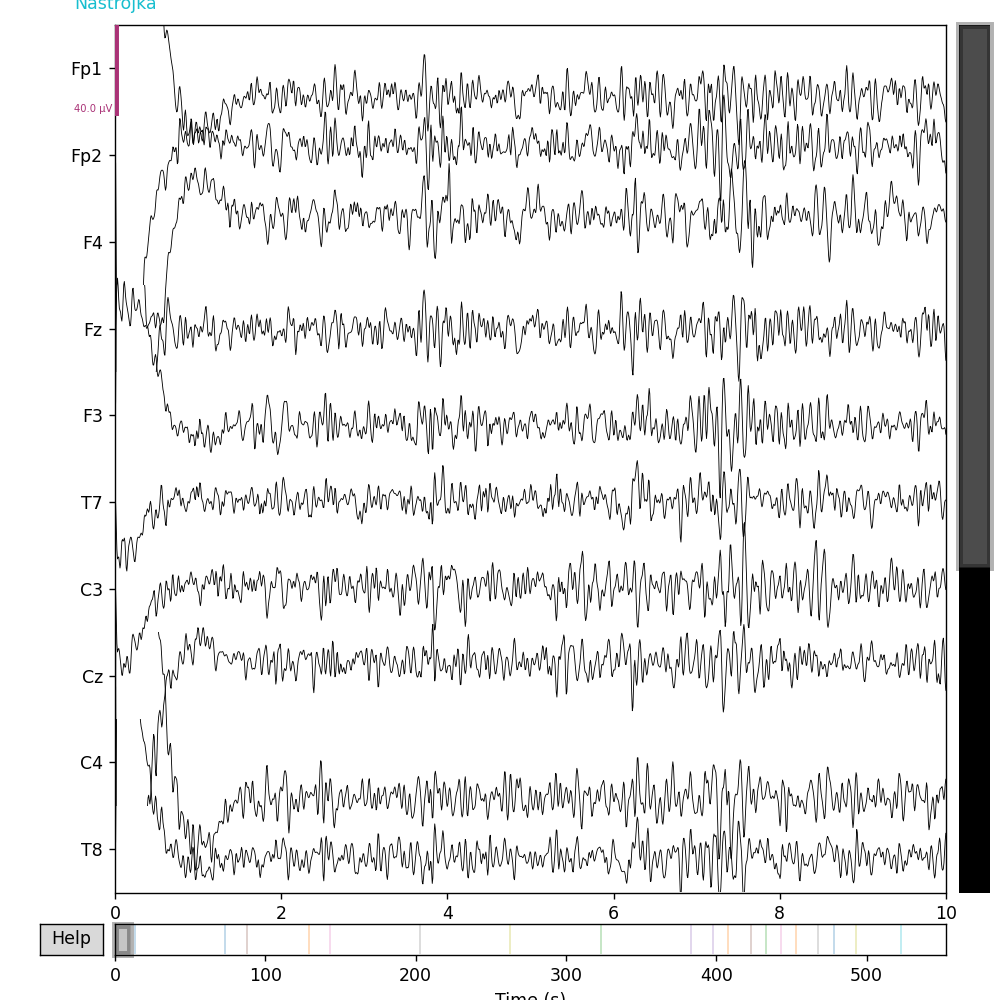

In [32]:
%matplotlib notebook

import matplotlib.pyplot as plt

fig = raw.plot(n_channels=10)

## ECG Artifacts

As we know from our course, the ECG signal may have a bad impact on the performance of the EEG. Heart potentials over the scalp of the head can generate noise that must be removed from the signal after. According to this article [1], people with short and wide necks are the ones that suffer the most from this interference.

We see on the last row of the plot, that there is almost no ECG noise, except for a small anomaly at the beginning when the recording just started, - the repairing must have been done already.

[1] https://www.medscape.com/answers/1140247-177025/what-are-ecg-artifacts-on-eeg

In [7]:
biosemi16_montage = mne.channels.make_standard_montage('biosemi16')
biosemi16_montage

<DigMontage | 0 extras (headshape), 0 HPIs, 3 fiducials, 16 channels>

In [8]:
raw.drop_channels('ECG')

mapping = dict(zip(raw.info['ch_names'], biosemi16_montage.ch_names))
raw.rename_channels(mapping)

<RawEDF | my_eeg.bdf, 16 x 221200 (553.0 s), ~27.0 MB, data loaded>

The information about the location of a signal is given in its channel's name. We need to manually agment it so man can beautifully colorize the plots.

In [9]:
raw_biosemi16 = raw.copy().set_montage(biosemi16_montage)

<IPython.core.display.Javascript object>


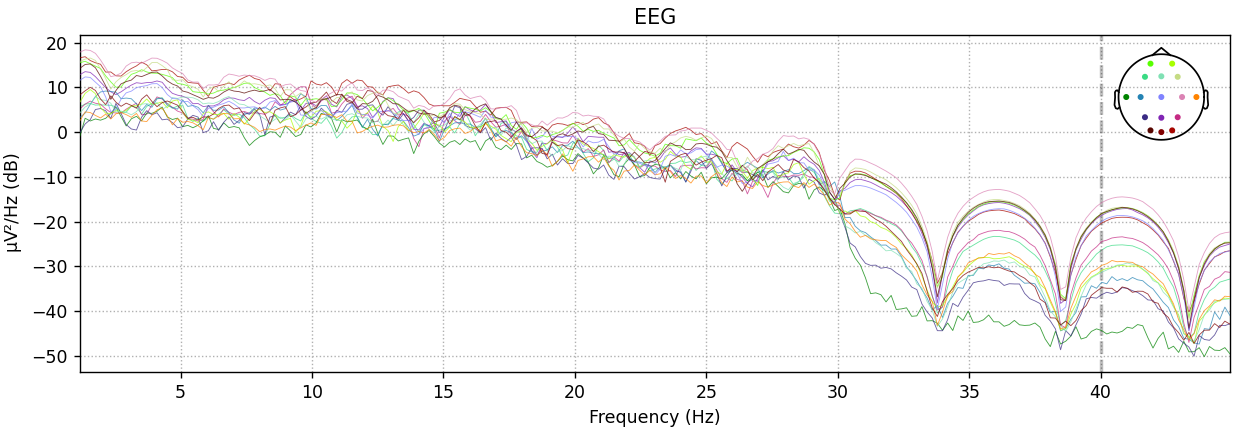

<IPython.core.display.Javascript object>


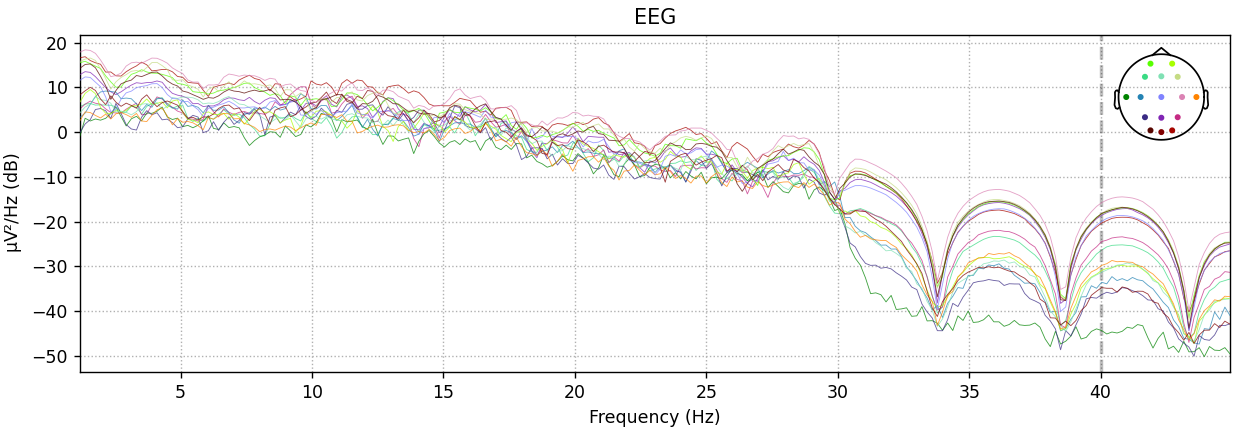

In [33]:
raw_biosemi16.plot_psd(fmin=1., fmax=45., tmax=60., average=False)

In [11]:
events, event_id = mne.events_from_annotations(raw_biosemi16)
      
print(events)

[[     0      0     18]
 [  5200      0     10]
 [ 29200      0     19]
 [ 35200      0     14]
 [ 51600      0     20]
 [ 57200      0     15]
 [ 81200      0     16]
 [105200      0     17]
 [129200      0      3]
 [153200      0     13]
 [159200      0      4]
 [163200      0     11]
 [169200      0      5]
 [173200      0     12]
 [177200      0      6]
 [181200      0      2]
 [187200      0      7]
 [191200      0      1]
 [197200      0      8]
 [209200      0      9]]


C:\Users\KENTIC~1\AppData\Local\Temp/ipykernel_15744/1600314362.py:1: RuntimeWarning: More events than default colors available. You should pass a list of unique colors.
  mne.viz.plot_events(events, raw_biosemi16.info['sfreq'], raw_biosemi16.first_samp, event_id=event_id)


<IPython.core.display.Javascript object>


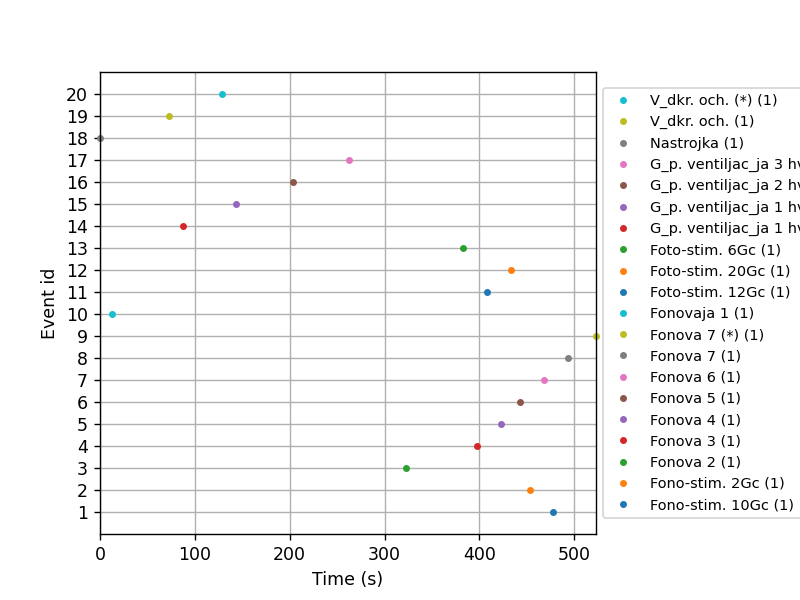

<IPython.core.display.Javascript object>


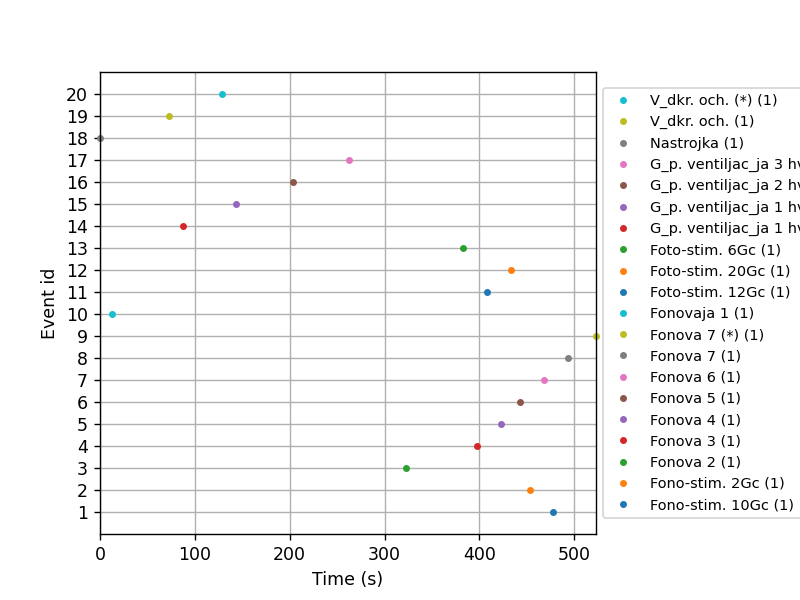

In [34]:
mne.viz.plot_events(events, raw_biosemi16.info['sfreq'], raw_biosemi16.first_samp, event_id=event_id)

In [13]:
import numpy as np

tmin, tmax = -0.1, 0.5

picks = np.arange(0, 16)

decim = 2
epochs = mne.Epochs(raw_biosemi16, events, event_id, tmin, tmax, proj=True,
                   picks=picks, preload=True, decim=decim)

print(epochs)

<Epochs |  19 events (all good), -0.1 - 0.5 sec, baseline -0.1 – 0 sec, ~315 kB, data loaded,
 'Fono-stim. 10Gc': 1
 'Fono-stim. 2Gc': 1
 'Fonova 2': 1
 'Fonova 3': 1
 'Fonova 4': 1
 'Fonova 5': 1
 'Fonova 6': 1
 'Fonova 7': 1
 'Fonova 7 (*)': 1
 'Fonovaja 1': 1
 'Foto-stim. 12Gc': 1
 'Foto-stim. 20Gc': 1
 'Foto-stim. 6Gc': 1
 'G_p. ventiljac_ja 1 hv.': 1
 'G_p. ventiljac_ja 1 hv. (*)': 1
 'G_p. ventiljac_ja 2 hv.': 1
 'G_p. ventiljac_ja 3 hv.': 1
 'Nastrojka': 0
 'V_dkr. och.': 1
 'V_dkr. och. (*)': 1>


In [14]:
data = epochs.get_data()
print(type(data))
print(data.shape)

<class 'numpy.ndarray'>
(19, 16, 121)


Text(0, 0.5, 'Data (fT)')

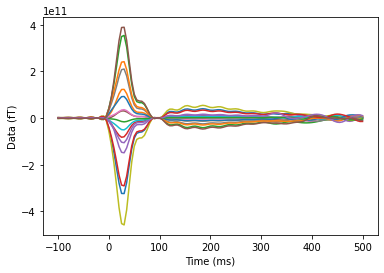

In [15]:
%matplotlib inline

plt.plot(1e3 * epochs.times, 1e15 * data[0, :, :].T)
plt.xlabel('Time (ms)')
plt.ylabel('Data (fT)')

Text(0, 0.5, 'Data (fT)')

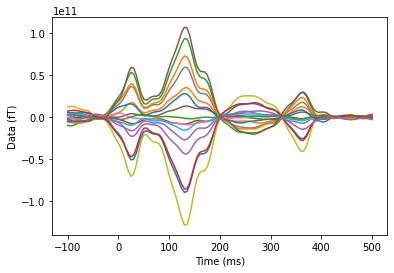

In [16]:
data_mean = np.mean(data, axis=0)

plt.plot(1e3 * epochs.times, 1e15 * data_mean.T)
plt.xlabel('Time (ms)')
plt.ylabel('Data (fT)')

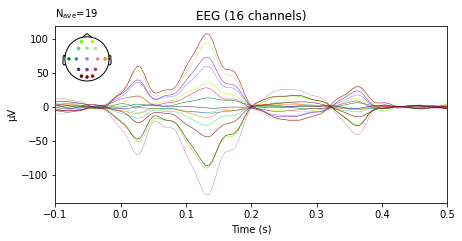

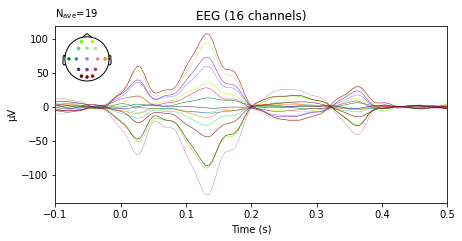

In [17]:
evoked = epochs.average()
evoked.plot(spatial_colors=True)

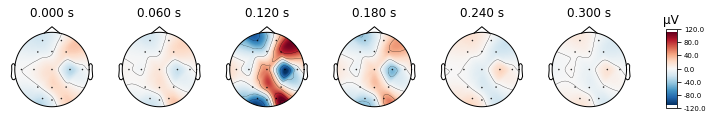

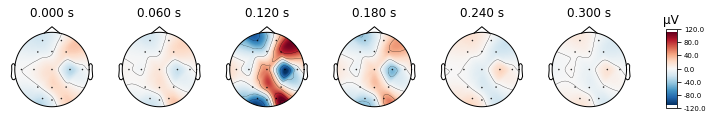

In [18]:
evoked.plot_topomap(times=np.linspace(0., 0.3, 6))

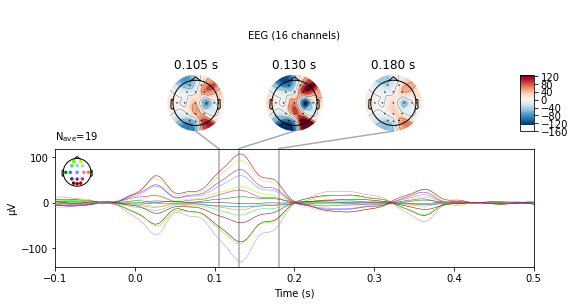

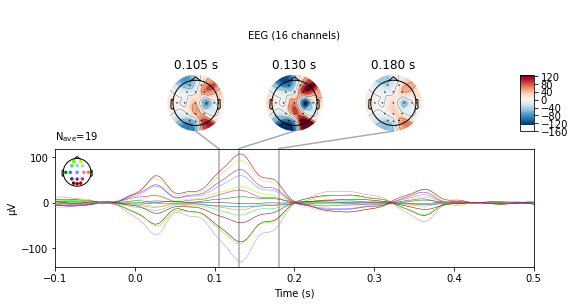

In [19]:
evoked.plot_joint(times=[0.105, 0.130, 0.180])

In [20]:
from ipywidgets import interact
import ipywidgets as widgets

@interact(time=(evoked.times[0], evoked.times[-1], 0.01),
          continuous_update=False)
def plot_topo(time):
    evoked.plot_topomap(times=[time], size=3., vmin=-250., vmax=250.)

interactive(children=(FloatSlider(value=0.19999999999999998, description='time', max=0.5, min=-0.1, step=0.01)…

In [21]:
import sys

!{sys.executable} -m pip install scikit-learn

In [22]:
from mne.preprocessing import ICA

ica = ICA(n_components=0.99, random_state=0).fit(epochs, decim=2)

C:\Users\KENTIC~1\AppData\Local\Temp/ipykernel_15744/802001892.py:3: RuntimeWarning: The epochs you passed to ICA.fit() were baseline-corrected. However, we suggest to fit ICA only on data that has been high-pass filtered, but NOT baseline-corrected.
  ica = ICA(n_components=0.99, random_state=0).fit(epochs, decim=2)


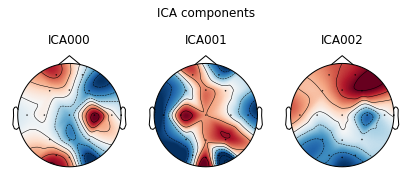

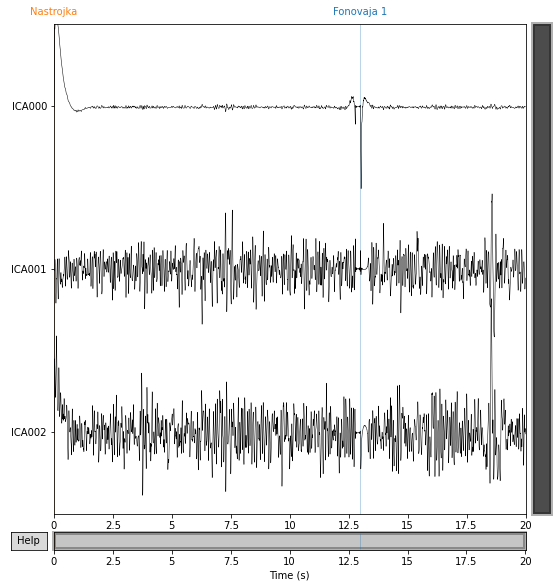

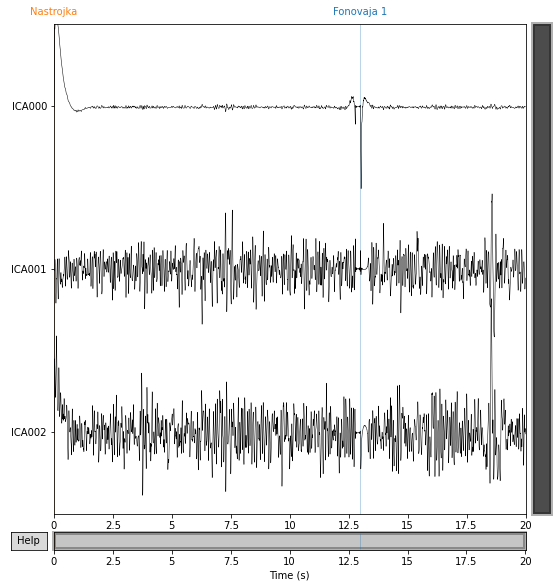

In [23]:
ica.plot_components()
ica.plot_sources(raw_biosemi16.copy().crop(0, 20), picks=range(3))

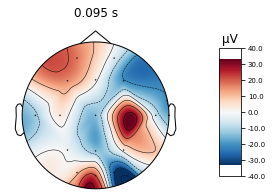

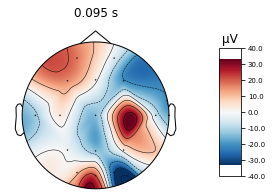

In [24]:
evoked_faces = epochs['Fono-stim. 10Gc'].average()
evoked_faces.plot_topomap(times=[0.095], size=2)

In [25]:
data = raw_biosemi16.get_data()
data

array([[ 4.02340650e-20, -4.90769135e-07,  6.31066358e-06, ...,
         9.78190961e-05,  5.50029742e-05,  2.32934060e-21],
       [-2.92226367e-20,  1.71564630e-07, -2.01866171e-06, ...,
        -2.19055232e-05, -1.22152973e-05,  2.22346149e-21],
       [-4.65868121e-20,  3.17836362e-07, -6.20154486e-06, ...,
        -5.84367273e-05, -3.26304577e-05, -1.05879118e-21],
       ...,
       [ 4.23516474e-20, -8.66194340e-07,  2.81898004e-06, ...,
         1.33975783e-05,  7.41354279e-06, -8.47032947e-22],
       [ 2.71050543e-20, -5.73642817e-07,  1.62134772e-06, ...,
         1.72967082e-05,  9.70713668e-06,  2.96461532e-21],
       [-6.26804381e-20,  8.48119651e-07, -6.68801765e-06, ...,
        -8.64776732e-05, -4.86841547e-05,  3.81164826e-21]])

In [26]:
from scipy import signal

f3 = data[2]
len_data_f3 = len(f3)
# Nyquist frequency
fs = 400 / 2

f, psd = signal.welch(f3, fs, nperseg=len_data_f3)

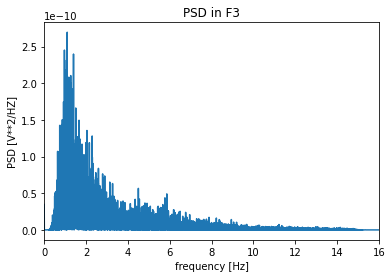

In [27]:
plt.figure()

plt.plot(f, psd)
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/HZ]')
plt.title('PSD in F3')
plt.xlim(0, 16)
plt.show()

In [28]:
import sys

!{sys.executable} -m pip install eeglib

In [29]:
dir(raw)

['__class__',
 '__contains__',
 '__del__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__enter__',
 '__eq__',
 '__exit__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setitem__',
 '__sizeof__',
 '__slotnames__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_annotations',
 '_cals',
 '_check_bad_segment',
 '_comp',
 '_data',
 '_dtype',
 '_dtype_',
 '_filenames',
 '_first_samps',
 '_first_time',
 '_get_buffer_size',
 '_get_channel_positions',
 '_getitem',
 '_handle_tmin_tmax',
 '_init_kwargs',
 '_last_samps',
 '_last_time',
 '_orig_units',
 '_parse_get_set_params',
 '_pick_drop_channels',
 '_pick_projs',
 '_preload_data',
 '_projector',
 '_projectors',
 '_raw_extras',
 '_raw_lengths',
 '_read_comp_grade',
 '_read_picks',
 '_read_segment',
 '_read_segment_file'

In [30]:
raw.ch_names

['Fp1',
 'Fp2',
 'F4',
 'Fz',
 'F3',
 'T7',
 'C3',
 'Cz',
 'C4',
 'T8',
 'P4',
 'Pz',
 'P3',
 'O1',
 'Oz',
 'O2']

In [ ]:
import eeglib

helper = eeglib.helpers.EDFHelper('my_eeg.edf',
                                 normalize=True, highpass=1, lowpass=50,
                                 selectedSignals=['O1', 'O2', 'F3', 'F4'])

helper.prepareEEG(helper.sampleRate*2)

helper.eeg.outputMode = 'dict'

wrap = eeglib.wrapper.Wrapper(helper[::'0.5'], segmentation=[(('0', '5'),0),
                                                            (('5','11'),1)])

wrap.addFeature.bandPower(hideArgs=True)
data = wrap.getAllFeatures()

In [ ]:
from sklearn.svm import SVC

X = data.drop(columns='segment_label')
y = data['segment_label']

clf = SVC()
clf.fit(X, y)

## Conclusions

During the EEG recording, an unstable alpha rhythm which had a frequency of 10.5-11 Hz and was amplified to 110 µV was dominating. Activation reaction was fuzzy: from the beginning of the EEG, the continuing functional loads provoked synchronized sharp discharges. After functional loads we can see discharges in form of sharp waves - both in the D hemisphere and later in the S hemisphere. They're also common in the fronto-precentral, temporal, and parieto occipital regions.